In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Input, Flatten
from tensorflow.keras.layers import TimeDistributed, Conv1D, Activation
from tensorflow.keras.layers import LayerNormalization, Add
from tensorflow.keras.layers import Lambda
import os

sensex_tickers = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS"]

start_date = input("Enter start date (YYYY-MM-DD): ")
end_date = input("Enter end date (YYYY-MM-DD): ")

def download_data(ticker):
    print(f'Downloading data for {ticker}')
    data = yf.download(ticker, start=start_date, end=end_date)
    if not data.empty:
        filename = f"{ticker.replace('.NS', '')}_data.csv"
        data.to_csv(filename)
        print(f'Data saved to {filename}')
        return data
    else:
        print(f'No data available for {ticker}')
        return None

# Download data for all tickers
stock_data = {}
for ticker in sensex_tickers:
    data = download_data(ticker)
    if data is not None:
        stock_data[ticker] = data


Enter start date (YYYY-MM-DD): 2022-01-01
Enter end date (YYYY-MM-DD): 2022-04-03


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data saved to RELIANCE_data.csv
Data saved to TCS_data.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data saved to HDFCBANK_data.csv
Data saved to INFY_data.csv


In [ ]:
def preprocess_data(data, look_back=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Open']])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# Preprocess all stocks data
preprocessed_data = {}
for ticker, data in stock_data.items():
    X, y, scaler = preprocess_data(data)
    preprocessed_data[ticker] = (X, y, scaler)


In [ ]:
def residual_block(x, dilation_rate):
    previous_block_activation = x  # residual connection

    x = LayerNormalization()(x)
    x = Conv1D(64, 3, padding="causal", dilation_rate=dilation_rate)(x)
    x = Activation("relu")(x)

    x = Conv1D(64, 3, padding="causal", dilation_rate=dilation_rate)(x)
    x = Add()([x, previous_block_activation])
    return x

def build_hybrid_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)

    # TCN layers
    x = residual_block(x, 1)
    x = residual_block(x, 2)
    x = residual_block(x, 4)

    x = Flatten()(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model
model = build_hybrid_model((60, 1))
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 60, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_32 (Conv1D)        │ (None, 58, 64)         │            256 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_33 (Conv1D)        │ (None, 56, 64)         │         12,352 │ conv1d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_12    │ (None, 56, 64)         │            128 │ conv1d_33[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_34 (Conv1D)        │ (None, 56, 64)         │         12,352 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12             │ (None, 56, 64)         │              0 │ conv1d_34[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_35 (Conv1D)        │ (None, 56, 64)         │         12,352 │ activation_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 56, 64)         │              0 │ conv1d_35[0][0],       │
│                           │                        │                │ conv1d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_13    │ (None, 56, 64)         │            128 │ add_12[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_36 (Conv1D)        │ (None, 56, 64)         │         12,352 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_13             │ (None, 56, 64)         │              0 │ conv1d_36[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_37 (Conv1D)        │ (None, 56, 64)         │         12,352 │ activation_13[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 56, 64)         │              0 │ conv1d_37[0][0],       │
│                           │                        │                │ add_12[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 56, 64)         │            128 │ add_13[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_38 (Conv1D)        │ (None, 56, 64)         │         12,352 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_14        

 Total params: 90,689 (354.25 KB)

 Trainable params: 90,689 (354.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def train_and_predict(ticker, X, y, scaler, epochs=20, batch_size=32):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = build_hybrid_model(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Save predictions and actual data to CSV
    result_df = pd.DataFrame({'Actual': actual.flatten(), 'Predicted': predictions.flatten()})
    result_filename = f"{ticker.replace('.NS', '')}_predictions.csv"
    result_df.to_csv(result_filename, index=False)
    print(f'Predictions saved to {result_filename}')

    return result_df

# Train and predict for all tickers
results = {}
for ticker, (X, y, scaler) in preprocessed_data.items():
    results[ticker] = train_and_predict(ticker, X, y, scaler)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 8.8394
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.1818
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.2095
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3805
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1852
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1111
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0745
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0621
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0439
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0375
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0213
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0193
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0159
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0175
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0122
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Predictions saved to INFY_predictions.csv


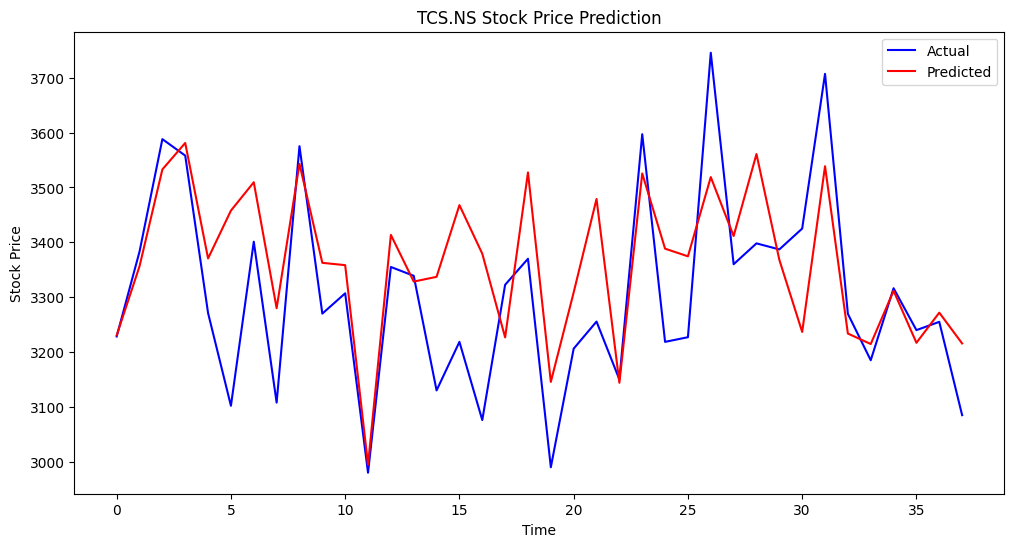

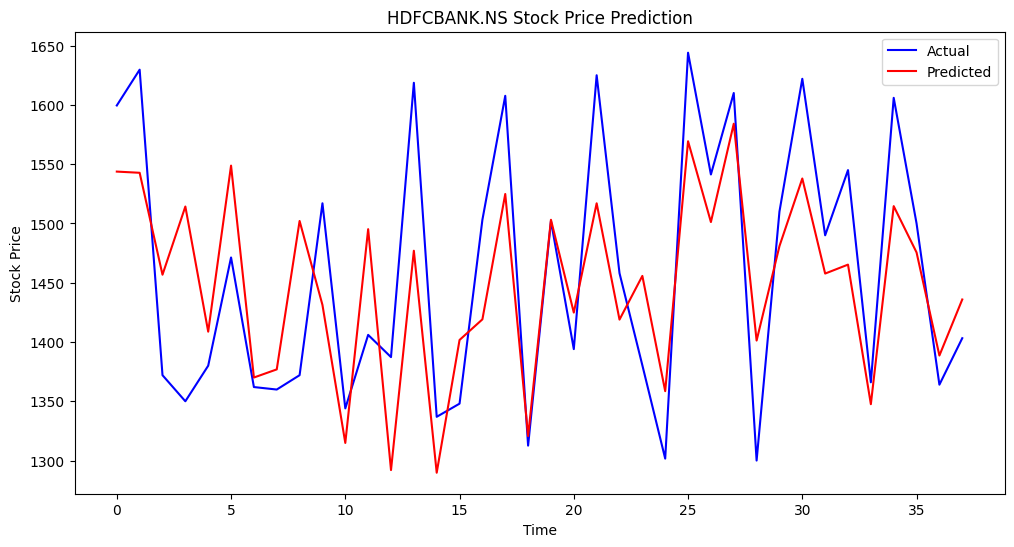

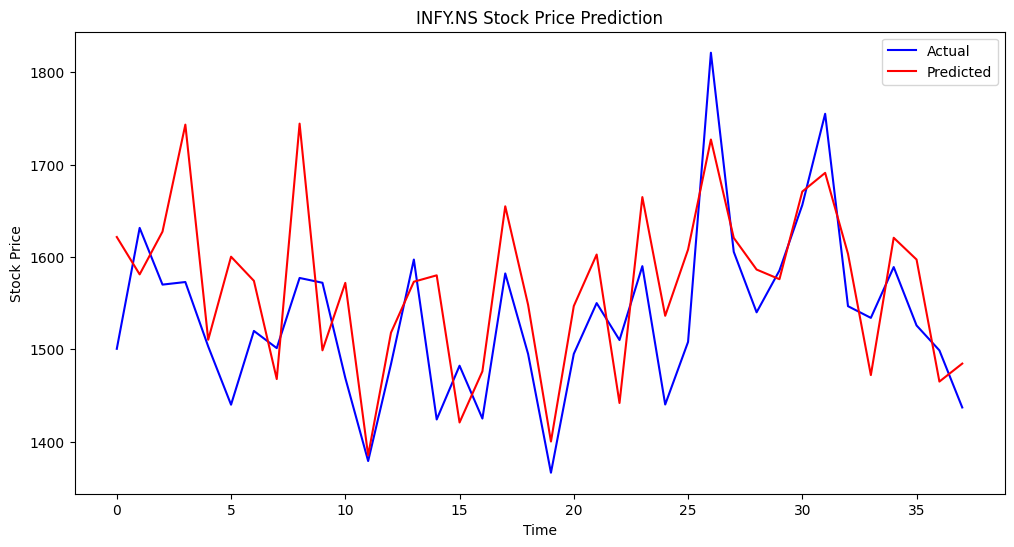

In [ ]:
def plot_predictions(ticker, result_df):
    plt.figure(figsize=(12, 6))
    plt.plot(result_df['Actual'], color='blue', label='Actual')
    plt.plot(result_df['Predicted'], color='red', label='Predicted')
    plt.title(f"{ticker} Stock Price Prediction")
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Plot predictions for all tickers
for ticker, result_df in results.items():
    plot_predictions(ticker, result_df)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_predictions(ticker, result_df):
    # Calculate MAE, MSE, RMSE, and R²
    mae = mean_absolute_error(result_df['Actual'], result_df['Predicted'])
    mse = mean_squared_error(result_df['Actual'], result_df['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(result_df['Actual'], result_df['Predicted'])

    # Calculate Directional Accuracy
    actual_direction = np.sign(result_df['Actual'].diff().dropna())
    predicted_direction = np.sign(result_df['Predicted'].diff().dropna())
    directional_accuracy = (actual_direction == predicted_direction).mean() * 100

    # Print metrics
    print(f"Metrics for {ticker}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R² Score: {r2}")
    print(f"Directional Accuracy: {directional_accuracy}%")

    # Return metrics as a dictionary for further use if needed
    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Directional Accuracy": directional_accuracy
    }

# Evaluate predictions for all tickers
metrics = {}
for ticker, result_df in results.items():
    metrics[ticker] = evaluate_predictions(ticker, result_df)

Metrics for TCS.NS:
Mean Absolute Error (MAE): 106.5439517372533
Mean Squared Error (MSE): 19319.08557973253
Root Mean Squared Error (RMSE): 138.993113425567
R² Score: 0.3976669119882281
Directional Accuracy: 81.08108108108108%
Metrics for HDFCBANK.NS:
Mean Absolute Error (MAE): 61.57369513260691
Mean Squared Error (MSE): 5283.651919196703
Root Mean Squared Error (RMSE): 72.68873309665469
R² Score: 0.5630531656112212
Directional Accuracy: 83.78378378378379%
Metrics for INFY.NS:
Mean Absolute Error (MAE): 65.24567935341284
Mean Squared Error (MSE): 6103.831377746637
Root Mean Squared Error (RMSE): 78.12702079144346
R² Score: 0.23684507233293295
Directional Accuracy: 72.97297297297297%
